In [184]:
import sys
sys.path.append('../')
import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.pure_fit_model as pure_fit_model

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

#1*0.99*0.99
ps=  torch.tensor([ [0.99, 0, 0, 0.01, 0],
                    [0, 0.75, 0.25, 0, 0],
                    [0, 0, 0.60, 0.40, 0],
                    [0, 0, 0, 0.95, 0.05],
                    [0, 0, 0, 0.00, 1.00]], device=device)

psMtrices= torch.stack([ps])
crossImmMatrix= torch.tensor([[0]], device=device)
#psMtrices= torch.stack([ps, ps, ps])
#crossImmMatrix= torch.tensor([[0, 1, 1],
#                              [1, 0, 1],
#                              [1, 1, 0]], device=device)



def load_linear(psMtrices, crossImmMatrix, device= device):
    tKn= psMtrices.shape[0]
    ts= 5
    Linear= torch.ones(tKn, tKn, 1, ts, ts, ts, device=device)
    for i in range(tKn): # k layer
        for j in range(tKn):# prod layer
            if i==j: #load paMatrices
                for k in range(ts):
                    Linear[j, i, 0, :, :, k]= psMtrices[i, ...].T
            else: #load crossImmMatrix
                Linear[j, i, 0, 2, 1, 3:5]= crossImmMatrix[j, i]#3:5 regarding position (2,1)
    return Linear



In [194]:
n= 1000
avgDegree= 6
timeHorizon= 600
Kn= 1
#3* 3, 16*4
Linear= load_linear(psMtrices, crossImmMatrix, device=device)

state= torch.zeros([Kn, n, 5, 1], device=device)# 3,1000,4,1
state[:, :, 1, 0]= 1
for i in range(Kn):
    firstInfected= random.randint(0, n-1)
    state[i, firstInfected, 0, 0]= 1 #go to hidden layer
    state[i, firstInfected, 1, 0]= 0
print(state.sum(dim=1))
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
contact= contact[None, ...]
mySig = torch.nn.Sigmoid()

tensor([[[  1.],
         [999.],
         [  0.],
         [  0.],
         [  0.]]], device='cuda:0')


In [195]:
#
stateHistory=[]
staticSI=[]
for i in range(timeHorizon):
    A= Linear.matmul(state[:, None, :, None, ...])
    Psts= torch.prod(A, dim=0)
    Psts= Psts.squeeze(dim=-1)
    sumPsts= Psts.sum(dim= -2)+ 1e-8
    sumPsts= sumPsts[:, :, None, :]
    Psts= Psts/sumPsts
    #print(state[0, ...])
    Psts2= Psts[:, :, 2, 1]
    s= state[:, :, 1:2, 0]
    i= state[:, :, 3:4, 0]
    s= s.permute(0, 2, 1)
    iSum= i.sum(dim=1)#k*1
    softSwitch= mySig((iSum-0.99)*1000)
    Temp= contact*i*s
    Temp= Temp*softSwitch[..., None]
    Psts2= 1-Temp*Psts2 [..., None]
    # print(i[0, ...])
    # print(s[0, ...])
    Psts2= 1-torch.prod(Psts2, dim=-2)
    Psts[:, :, 2, 1]= Psts2
    Psts[:, :, 1, 1]= 1- Psts2
    Psts[:, :, 4, 3]= Psts[:, :, 4, 3]*(softSwitch)
    Psts[:, :, 3, 3]= 1-Psts[:, :, 4, 3]
    
    #print(Psts[0])
    #print(state.shape)
    #state= state.squeeze(dim=-1)
    state= Psts.matmul(state)
    #print(state[0])
    stateHistory.append(state.sum(dim=1))
    prob0= 1-state[0, :, 0, 0]
    #prob1= 1-state[1, :, 2, 0]
    #prob2= 1-state[2, :, 2, 0]
    statisticI= 1-prob0
    staticSI.append(statisticI.sum().item())
    #prob1= 1-stateHistoryPlot[:, 0, 1, 0]
    #prob2= 1-stateHistoryPlot[:, 0, 2, 0]
    
stateHistory= torch.stack(stateHistory)
stateHistoryPlot= stateHistory.cpu().detach()

torch.Size([1000])
600


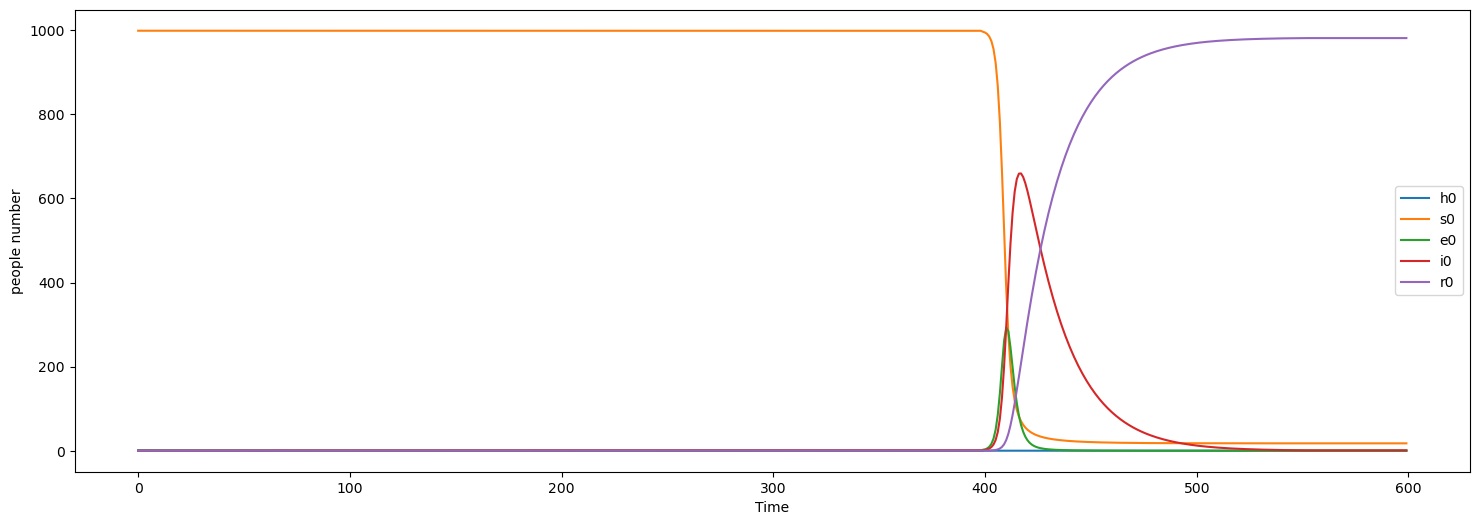

In [196]:

stateHistoryPlot0= stateHistoryPlot[:, 0, :, 0]
# stateHistoryPlot1= stateHistoryPlot[:, 1, :, 0]
# stateHistoryPlot2= stateHistoryPlot[:, 2, :, 0]
print(statisticI.shape)
plt.figure(figsize=(18,6))
plt.plot(stateHistoryPlot0, label=["h0", "s0", "e0", "i0", "r0"])
# plt.plot(stateHistoryPlot1, label=["s1", "e1", "i1", "r1"])
# plt.plot(stateHistoryPlot2, label=["s2", "e2", "i2", "r2"])
# for i, _ in enumerate(staticSI):
#     staticSI[i]= i*staticSI[i]
#plt.plot(staticSI, label="I")
print(len(staticSI))
plt.xlabel("Time")
#plt.ylabel("Infectiveness number")
plt.ylabel("people number")
plt.legend()

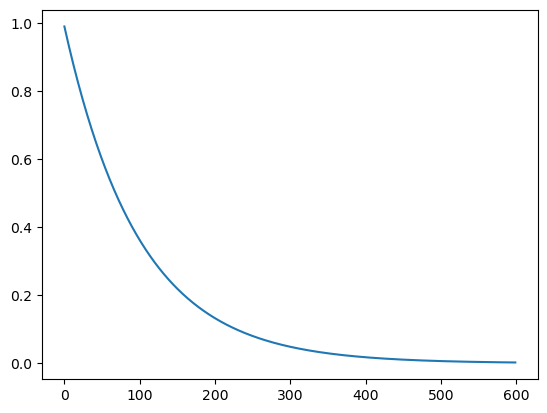

In [197]:
plt.plot(staticSI, label="I")

In [44]:
Linear= torch.randn(3, 3, 4, 4, 4)
state= torch.randn(3,4,100)
contact= torch.randn(100, 100)
A= Linear.matmul(state[:, None, None, ...])
Psts= torch.prod(A, dim=0)
Psts1= Psts*mask1
Psts2= Psts*mask2
s= state[:, 0:1, :]
i= state[:, 2:3, :]
s= s.permute(0, 2, 1)
Temp= contact*i*s
Temp= Temp[:, None, None, ...]
Psts2= Psts2[:, :, :, None, :]
print(Temp.shape)
print(Psts2.shape)
Psts2= 1-Temp*Psts2
Psts2= 1-torch.prod(Psts2, dim=-1)
Psts3= (1-Psts2)*Tm
Psts= Psts1+Psts2+Psts3
Psts= Psts.permute(0, 3, 1, 2)
state= state[:, :, None, :].permute(0, 3, 1, 2)
state= Psts.matmul(state)
print(Psts.shape)
print(state.shape)

torch.Size([3, 1, 1, 100, 100])
torch.Size([1, 3, 4, 1, 4, 100])


RuntimeError: The size of tensor a (100) must match the size of tensor b (4) at non-singleton dimension 4

In [ ]:
a= torch.randn(2, 2, 4, 4, 4)
b= torch.randn(2, 4, 10)
c= torch.rand(2, 3, 1)
print(c)

In [ ]:
temp= b.permute(2, 0, 1)
print(temp.shape)

In [ ]:
c= a.matmul(b)
d= torch.prod(c, dim=0)
mask1= torch.tensor([ [1, 0, 0, 0]
                     ,[0, 0, 0, 0]
                     ,[0, 0, 0, 0]
                     ,[0, 0, 0, 0]])
mask1=mask1[None, ..., None]
d= mask1*d
print(d.shape)
d= d[:, :, :, None, :]
print(mask1.shape)
print(c.shape)
print(d.shape)


In [ ]:
contact= torch.randn(10, 10)
i= torch.rand(2, 1, 10)
s= torch.rand(2, 1, 10)
m= contact*i*s
print(m.shape)
m= m[:, None, None, ...]
m= m*d
m= torch.prod(m, dim=-1)
print(m.shape)
print(m[0, :, :, 0])

torch.Size([2, 10, 10])


NameError: name 'd' is not defined